In [2]:
# imports
import os
import sys
import dvc.api
import mlflow
import pandas as pd
import numpy as np
import joblib
import datetime
import matplotlib.pyplot as plt
from prophet.forecaster import Prophet
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, ShuffleSplit, cross_val_score, cross_validate

In [3]:
# adding and setting up scripts
sys.path.append('.')
sys.path.append('..')
sys.path.insert(1, '../scripts/')
import defaults as defs
import dataCleaner as dc
import dataVisualizer as dv

cleaner = dc.dataCleaner('prophet modeling notebook')
visualizer = dv.dataVisualizer('prophet modeling notebook')

--> <Logger dataCleaner (WARNING)>
logger <Logger dataCleaner (DEBUG)> created at path: ../logs/cleaner_root.log
Data cleaner in action
--> <Logger dataVisualizer (WARNING)>
logger <Logger dataVisualizer (DEBUG)> created at path: ../logs/visualizer_root.log
Data visualizer in action


In [4]:
# pandas settings
pd.set_option('display.max_columns', 30)

# version of the data
# v1 : gdrive 
# v2 : local messed up store
# v3 : local correct store
# v4 : local store: merged data file generated, data preparation completed
version = 'v4'

# read data sets using dvc api
test_data_url = dvc.api.get_url(path = defs.test_local_path, 
                                repo = defs.repo, 
                                rev = version)

train_data_url = dvc.api.get_url(path = defs.train_local_path, 
                                repo = defs.repo, 
                                rev = version)

full_data_url = dvc.api.get_url(path = defs.merged_local_path, 
                                repo = defs.repo, 
                                rev = version)

print('test data path: ' + test_data_url, '\ntrain data path: ' + train_data_url, '\nmerged data path: ' + full_data_url)

test data path: /.dvc/C:\Users\f0x-tr0t\Documents\education\datascience\dvc-storage/d5/d6373bc6743cde41c22b4599dce90c 
train data path: /.dvc/C:\Users\f0x-tr0t\Documents\education\datascience\dvc-storage/1f/38ace4291877fe3b742e8b7a111377 
merged data path: /.dvc/C:\Users\f0x-tr0t\Documents\education\datascience\dvc-storage/2c/45c8bfea2787f193cb56fe88d8df04


In [5]:
# reading csv files
DateCols = ['Date']
missing_values = ["n/a", "na", "undefined", '?', 'NA', 'undefined']

test_data = pd.read_csv(defs.test_local_path, na_values=missing_values, parse_dates=DateCols)
train_data = pd.read_csv(defs.train_local_path, na_values=missing_values, parse_dates=DateCols)
full_data = pd.read_csv(defs.merged_local_path, na_values=missing_values, parse_dates=DateCols)

# Sales forecast using Prophet

## Some feature eng.

In [6]:
#full_data[full_data['StateHoliday'] == 'd'] # array(['c', 'a', 'd', 'b'], dtype = object)
#full_data['StateHoliday'].unique() # array(['0', 'a', 'b', 'c'], dtype = object)
#full_data['Assortment'].unique() # array(['a', 'c', 'b'], dtype = object)
#full_data['SchoolHoliday'].unique() # array([1, 0], dtype = int64)
#full_data['Store'].unique() # array([   1,    2,    3, ..., 1113, 1114, 1115], dtype = int64)

In [7]:
#cols_to_drop = ['Year', 'Month', 'DayOfMonth', 'WeekOfYear', 'DayOfWeek', 'weekday', 'PromoInterval']
#df = full_data.drop(cols_to_drop, axis = 1)

full_data_columns = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'Year', 'Month', 'DayOfMonth',
                    'WeekOfYear', 'weekday', 'StoreType', 'Assortment',
                    'CompetitionDistance', 'CompetitionOpenSinceMonth',
                    'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval', 'PromoInterval0', 'PromoInterval1',
                    'PromoInterval2', 'PromoInterval3']

df = train_data[['Store', 'DayOfWeek', 'Date', 'Customers', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'Sales']]
                    
custom_cols = ['Store', 'DayOfWeek', 'ds', 'Customers', 'Open', 'Promo',
                    'StateHoliday', 'SchoolHoliday', 'y']
df.columns = custom_cols
df = df[0:50000] 
df.head(10)

,Store,DayOfWeek,ds,Customers,Open,Promo,StateHoliday,SchoolHoliday,y
0,1,5,2015-07-31,555,1,1,0,1,5263
1,2,5,2015-07-31,625,1,1,0,1,6064
2,3,5,2015-07-31,821,1,1,0,1,8314
3,4,5,2015-07-31,609,1,1,0,1,13995
4,5,5,2015-07-31,559,1,1,0,1,4822
5,6,5,2015-07-31,589,1,1,0,1,5651
6,7,5,2015-07-31,1414,1,1,0,1,5744
7,8,5,2015-07-31,833,1,1,0,1,8492
8,9,5,2015-07-31,687,1,1,0,1,8565
9,10,5,2015-07-31,681,1,1,0,1,7185


In [8]:
X_train = df.loc[train_data['Date']<'2015-01-01']
X_test = df.loc[train_data['Date']>='2015-01-01']

In [33]:
y = np.array(df['y'])
y.reshape(-1, 1)

array([[5263],
       [6064],
       [8314],
       ...,
       [9392],
       [6372],
       [8239]])

## Training

In [34]:
forecast_model = Prophet(interval_width = 0.95, daily_seasonality = True)

forecast_pipe = Pipeline([('label encoder', preprocessing.LabelEncoder),
                ('standard scaler', preprocessing.StandardScaler()), 
                ('forecast model', forecast_model)])

# shuffle split using 5 folds and tet size of 2%
cv = ShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 77)
#scoring = ['r2', 'neg_mean_squared_error', 'neg_root_mean_squared_error', 'neg_mean_absolute_error', 'accuracy', 'precision']
scoring = ['r2', 'accuracy', 'precision']


# set up the data, differentiating the training features and the target
X = df.iloc[: , :-1 ]
y = np.array(df['y'])
y.reshape(-1, 1)

#fitted_model = forecast_pipe.fit(X, pd.np.array(y).reshape(1, -1)) # 50,000 records took 2m 20.1s

#save the model
joblib.dump(forecast_pipe._final_estimator, '../models/prophet_model.pkl')

['../models/prophet_model.pkl']

In [27]:
forecast_model = Prophet(interval_width = 0.95, daily_seasonality = True)
model = forecast_model.fit(df) # 50,000 records took 1m

17:44:40 - cmdstanpy - INFO - Chain [1] start processing
17:45:36 - cmdstanpy - INFO - Chain [1] done processing


## Forecast

In [29]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41088 entries, 0 to 41087
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Id             41088 non-null  int64         
 1   Store          41088 non-null  int64         
 2   DayOfWeek      41088 non-null  int64         
 3   Date           41088 non-null  datetime64[ns]
 4   Open           41088 non-null  int64         
 5   Promo          41088 non-null  int64         
 6   StateHoliday   41088 non-null  int64         
 7   SchoolHoliday  41088 non-null  int64         
dtypes: datetime64[ns](1), int64(7)
memory usage: 2.5 MB


In [30]:
#future = forecast_model.make_future_dataframe(periods = 100, freq = 'D')
#forecast = forecast_model.predict(future)

test_data.drop('Id', axis = 1, inplace = True)
test_data.columns = ['Store', 'DayOfWeek', 'ds', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday']
forecast = forecast_model.predict(test_data)    # 56.6s
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-08-01,8789.876931,3453.374125,11196.826832,8789.876931,8789.876931,-1378.406169,-1378.406169,-1378.406169,-1155.594099,-1155.594099,-1155.594099,-222.812069,-222.812069,-222.812069,0.0,0.0,0.0,7411.470762
1,2015-08-01,8789.876931,3721.502341,11462.431582,8789.876931,8789.876931,-1378.406169,-1378.406169,-1378.406169,-1155.594099,-1155.594099,-1155.594099,-222.812069,-222.812069,-222.812069,0.0,0.0,0.0,7411.470762
2,2015-08-01,8789.876931,3065.489617,11677.299111,8789.876931,8789.876931,-1378.406169,-1378.406169,-1378.406169,-1155.594099,-1155.594099,-1155.594099,-222.812069,-222.812069,-222.812069,0.0,0.0,0.0,7411.470762
3,2015-08-01,8789.876931,3294.931262,11457.616618,8789.876931,8789.876931,-1378.406169,-1378.406169,-1378.406169,-1155.594099,-1155.594099,-1155.594099,-222.812069,-222.812069,-222.812069,0.0,0.0,0.0,7411.470762
4,2015-08-01,8789.876931,3279.998205,11402.856242,8789.876931,8789.876931,-1378.406169,-1378.406169,-1378.406169,-1155.594099,-1155.594099,-1155.594099,-222.812069,-222.812069,-222.812069,0.0,0.0,0.0,7411.470762
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41083,2015-09-17,22942.197068,-63587.672317,107942.311395,-62884.685219,108559.800382,-393.751392,-393.751392,-393.751392,-1155.594099,-1155.594099,-1155.594099,761.842707,761.842707,761.842707,0.0,0.0,0.0,22548.445676
41084,2015-09-17,22942.197068,-62816.355587,106345.112248,-62887.287052,108564.381117,-393.751392,-393.751392,-393.751392,-1155.594099,-1155.594099,-1155.594099,761.842707,761.842707,761.842707,0.0,0.0,0.0,22548.445676
41085,2015-09-17,22942.197068,-63162.525645,108563.807001,-62889.888884,108568.961852,-393.751392,-393.751392,-393.751392,-1155.594099,-1155.594099,-1155.594099,761.842707,761.842707,761.842707,0.0,0.0,0.0,22548.445676
41086,2015-09-17,22942.197068,-63168.794988,108631.075945,-62892.490717,108573.599649,-393.751392,-393.751392,-393.751392,-1155.594099,-1155.594099,-1155.594099,761.842707,761.842707,761.842707,0.0,0.0,0.0,22548.445676


### Plots

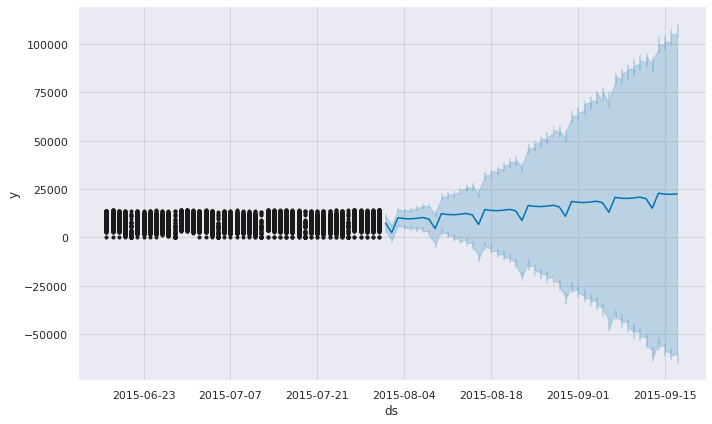

In [31]:
plot1 = forecast_model.plot(forecast)

* Small upward trend is observed
* There is also quite undeniable seasonality

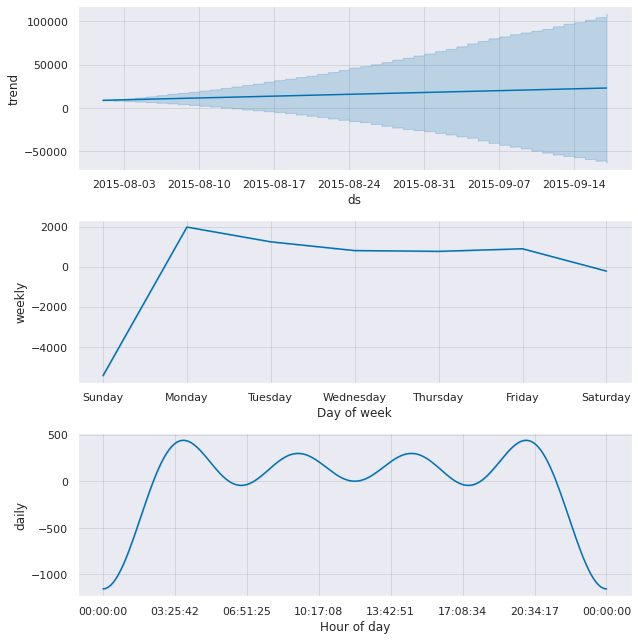

In [32]:
plot2 = forecast_model.plot_components(forecast)

* These are weekly and daily forecasts for the time series pharmaceutical data 